<ipython-input-1-360da5a51585>:20: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - loss: 1.0687e-04 - val_loss: 0.0019
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 1.0289e-05 - val_loss: 0.0019
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 1.2327e-05 - val_loss: 0.0016
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 9.4094e-06 - val_loss: 4.9646e-04
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 1.1362e-05 - val_loss: 8.7935e-04
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 8.0521e-06 - val_loss: 5.5411e-04
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 1.2085e-05 - val_loss: 0.0036
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 7.4818e-06 - val_loss: 0.0027
Epoch 9/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 8.1848e-06 - val_loss: 0.0022
Model saved as 'stock_price_prediction_model.h5'.
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Root Mean Squared Error: 5.527826468469969


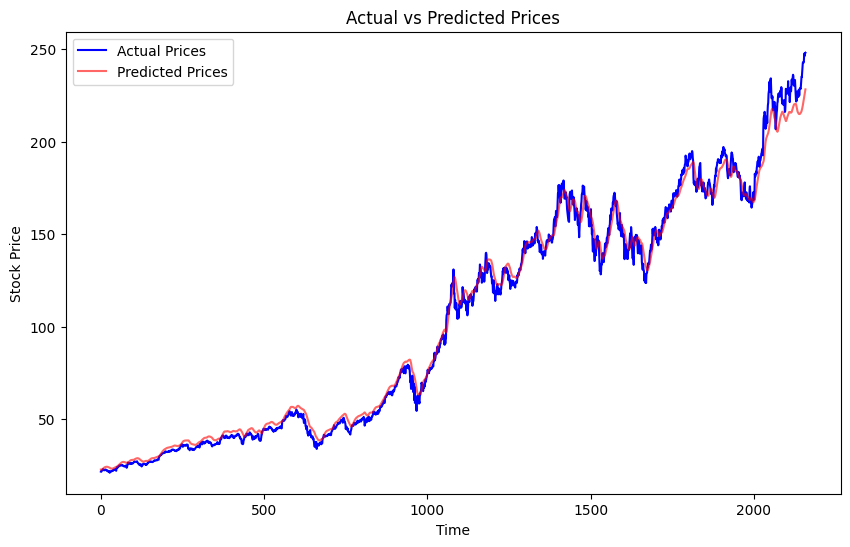

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Load the dataset
data = pd.read_csv('/kaggle/input/apple-stock-market-data-19802024/AAPL_historical_data.csv')
data.head()

# Check for null values and drop them
data = data.dropna()

# Convert 'Date' column to datetime format and sort data by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Feature selection: Use 'Open', 'High', 'Low', and 'Close' for prediction
features = ['Open', 'High', 'Low', 'Close']

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Prepare training and test datasets
def create_sequences(dataset, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(dataset)):
        X.append(dataset[i-sequence_length:i, :-1])  # Use 'Open', 'High', 'Low' as input
        y.append(dataset[i, -1])  # Use 'Close' as target
    return np.array(X), np.array(y)

sequence_length = 60  # Use 60 days of data to predict the next day's price
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the trained model
model.save('stock_price_prediction_model.h5')
print("Model saved as 'stock_price_prediction_model.h5'.")

# Predict on test data
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices), 3)), predicted_prices), axis=1))[:, -1]
actual_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 3)), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Evaluate the model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f'Root Mean Squared Error: {rmse}')

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red', alpha=0.6)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()








